In [1]:
for i in range(100):
	if i % 10 == 0:
		a = 23
	print(f"{i} {a}")

0 23
1 23
2 23
3 23
4 23
5 23
6 23
7 23
8 23
9 23
10 23
11 23
12 23
13 23
14 23
15 23
16 23
17 23
18 23
19 23
20 23
21 23
22 23
23 23
24 23
25 23
26 23
27 23
28 23
29 23
30 23
31 23
32 23
33 23
34 23
35 23
36 23
37 23
38 23
39 23
40 23
41 23
42 23
43 23
44 23
45 23
46 23
47 23
48 23
49 23
50 23
51 23
52 23
53 23
54 23
55 23
56 23
57 23
58 23
59 23
60 23
61 23
62 23
63 23
64 23
65 23
66 23
67 23
68 23
69 23
70 23
71 23
72 23
73 23
74 23
75 23
76 23
77 23
78 23
79 23
80 23
81 23
82 23
83 23
84 23
85 23
86 23
87 23
88 23
89 23
90 23
91 23
92 23
93 23
94 23
95 23
96 23
97 23
98 23
99 23


In [1]:
import math

math.pow(0.999, 20)

0.9801888648295347

In [1]:
import math
math.sqrt(7)

2.6457513110645907

epoch  20 | loss 2.2473


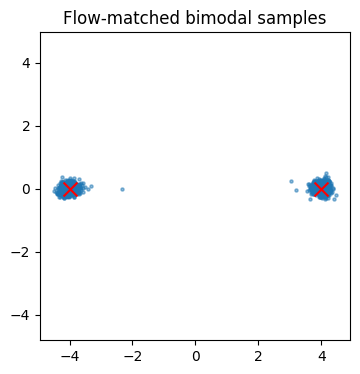

In [ ]:
import torch, math, random
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

# ------------------ 1. 目标分布：双峰 ------------------
d = 2                          # 数据维度
modes = torch.tensor([[-4., 0.],
                      [ 4., 0.]], device=device)  # 两个模态坐标

def sample_target(batch):
    """从目标分布采样 y。这里是两个 Dirac 点，也可加小噪声形成高斯."""
    idx = torch.randint(0, 2, (batch,), device=device)
    return modes[idx] + torch.randn_like(modes[idx]) * 0.1  # 加点噪声，形成高斯

# ------------------ 2. 向量场网络 v_θ(x, t) ------------------
class VecField(nn.Module):
    def __init__(self, hidden=128, layers=4):
        super().__init__()
        # 输入 = x (d) + t (1)
        dims = [d + 1] + [hidden] * (layers - 1) + [d]
        self.fcs = nn.ModuleList(
            nn.Linear(dims[i], dims[i + 1]) for i in range(len(dims) - 1)
        )

    def forward(self, x, t):
        xt = torch.cat([x, t], dim=-1)          # (B, d+1)
        h = xt
        for fc in self.fcs[:-1]:
            h = F.gelu(fc(h))
        return self.fcs[-1](h)                  # (B, d)

model = VecField().to(device)

# ------------------ 3. Flow-Matching 损失 ------------------
def fm_loss(batch_size):
    # 3.1 采样 (z, y, t)
    z = torch.randn(batch_size, d, device=device)        # prior N(0,I)
    y = sample_target(batch_size)                        # 目标样本
    t = torch.rand(batch_size, 1, device=device)         # U[0,1]

    # 3.2 线性插路径 x_t = (1-t)z + t y
    x_t = (1 - t) * z + t * y

    # 3.3 解析“真”向量场 v* = y - z   (与 t 无关)
    v_star = y - z

    # 3.4 预测向量场
    v_hat = model(x_t, t)

    # 3.5 L2 损失
    return F.mse_loss(v_hat, v_star)

# ------------------ 4. 训练循环 ------------------
opt = Adam(model.parameters(), lr=2e-4)
epochs, steps_per_epoch, bs = 20, 500, 512

for epoch in range(epochs):
    loss_avg = 0.
    for _ in range(steps_per_epoch):
        loss = fm_loss(bs)
        opt.zero_grad()
        loss.backward()
        opt.step()
        loss_avg += loss.item()
    if (epoch + 1) % 20 == 0:
        print(f"epoch {epoch+1:3d} | loss {loss_avg/steps_per_epoch:.4f}")

# ------------------ 5. 采样函数 (Euler 或 RK4) ------------------
@torch.no_grad()
def sample_from_flow(n_samples=1000, steps=1000, method="euler"):
    x = torch.randn(n_samples, d, device=device)
    dt = 1.0 / steps
    for i in range(steps):
        t = torch.full((n_samples, 1), i * dt, device=device)
        v = model(x, t)
        if method == "euler":
            x = x + v * dt
        elif method == "rk4":                   # 更精确但稍慢
            k1 = v
            k2 = model(x + 0.5 * dt * k1, t + 0.5 * dt)
            k3 = model(x + 0.5 * dt * k2, t + 0.5 * dt)
            k4 = model(x + dt * k3, t + dt)
            x = x + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)
    return x.cpu()

# ------------------ 6. 可视化验证 ------------------
samples = sample_from_flow(4000, steps=800, method="rk4")
plt.figure(figsize=(4, 4))
plt.scatter(samples[:, 0], samples[:, 1], s=5, alpha=0.5)
plt.scatter(modes[:, 0].cpu(), modes[:, 1].cpu(), c="red", marker="x", s=100)
plt.axis("equal"); plt.title("Flow-matched bimodal samples")
plt.show()


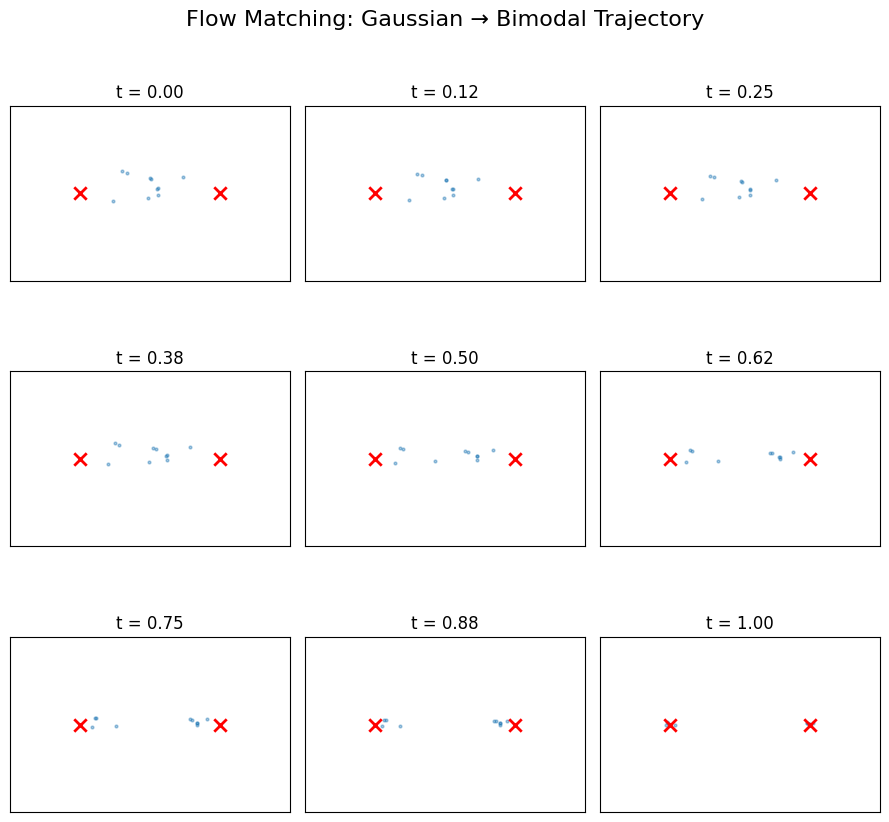

xas: tensor([[ 0.0515181646,  0.8238704801],
        [ 0.4422259629,  0.2933823764],
        [-2.1247150898, -0.4302273691],
        [-1.6027384996,  1.2587628365],
        [ 0.0086135203,  0.8725230098],
        [-1.3262029886,  1.1569342613],
        [-0.0863395929, -0.2708333731],
        [ 1.8715302944,  0.9363093972],
        [ 0.4286983907, -0.1131225750],
        [ 0.4215121865,  0.2633655071]]), 
 xbs: tensor([[ 3.8452954292,  0.0965253413],
        [ 3.9570729733,  0.0462065637],
        [-4.2194271088, -0.0435035378],
        [-4.1495223045,  0.1160616130],
        [ 3.8091645241,  0.1020722687],
        [-4.1125130653,  0.1044461876],
        [-3.6928391457, -0.0352107584],
        [ 4.1617703438,  0.1072716117],
        [ 3.9592266083,  0.0095083741],
        [ 3.9539203644,  0.0434883796]])



In [28]:
# ------------------ 5'. 采样并记录轨迹 ------------------
@torch.no_grad()
def sample_trajectory(n_samples=1000,
					  steps=1000,
					  record_frames=10,   # 记录多少张快照
					  method="euler"):
	"""
	返回 list[x_t]，长度 = record_frames + 1。
	x_t[0] 是 t=0 (高斯)，x_t[-1] 是 t=1 (目标)。
	"""
	x = torch.randn(n_samples, d, device=device)
	dt = 1.0 / steps
	xas = x.detach().cpu()  # 初始 x，用于可视化

	# 预先决定需要保存的 step 索引
	save_idx = torch.linspace(0, steps, record_frames + 1, dtype=torch.long)
	frames = []

	for i in range(steps + 1):
		if i in save_idx:               # 保存当前 x
			frames.append(x.detach().cpu())
		if i == steps:                  # 已到 t=1，结束
			break

		t = torch.full((n_samples, 1), i * dt, device=device)
		v = model(x, t)

		if method == "euler":
			x = x + v * dt
		else:                           # RK4
			k1 = v
			k2 = model(x + 0.5 * dt * k1, t + 0.5 * dt)
			k3 = model(x + 0.5 * dt * k2, t + 0.5 * dt)
			k4 = model(x + dt * k3,      t + dt)
			x = x + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)
	xbs = x.detach().cpu()  # 最终 x，用于可视化

	return frames, xas, xbs            # list[Tensor]，每个 (B, d)
# ------------------ 6'. 可视化演进 ------------------
frames, xas, xbs = sample_trajectory(n_samples=10,
						   steps=10,
						   record_frames=8,
						   method="rk4")

fig, axes = plt.subplots(3, 3, figsize=(9, 9))
axes = axes.flatten()

for k, (ax, pts) in enumerate(zip(axes, frames)):
	ax.scatter(pts[:, 0], pts[:, 1], s=4, alpha=0.4)
	ax.scatter(modes[:, 0].cpu(), modes[:, 1].cpu(),
			   c="red", marker="x", s=80, linewidths=2)
	ax.set_title(f"t = {k / (len(frames)-1):.2f}")
	ax.set_xlim(-8, 8); ax.set_ylim(-5, 5)
	ax.set_xticks([]); ax.set_yticks([]); ax.set_aspect("equal")

fig.suptitle("Flow Matching: Gaussian → Bimodal Trajectory", fontsize=16)
plt.tight_layout()
plt.show()

print(f"xas: {xas}, \n xbs: {xbs}\n")


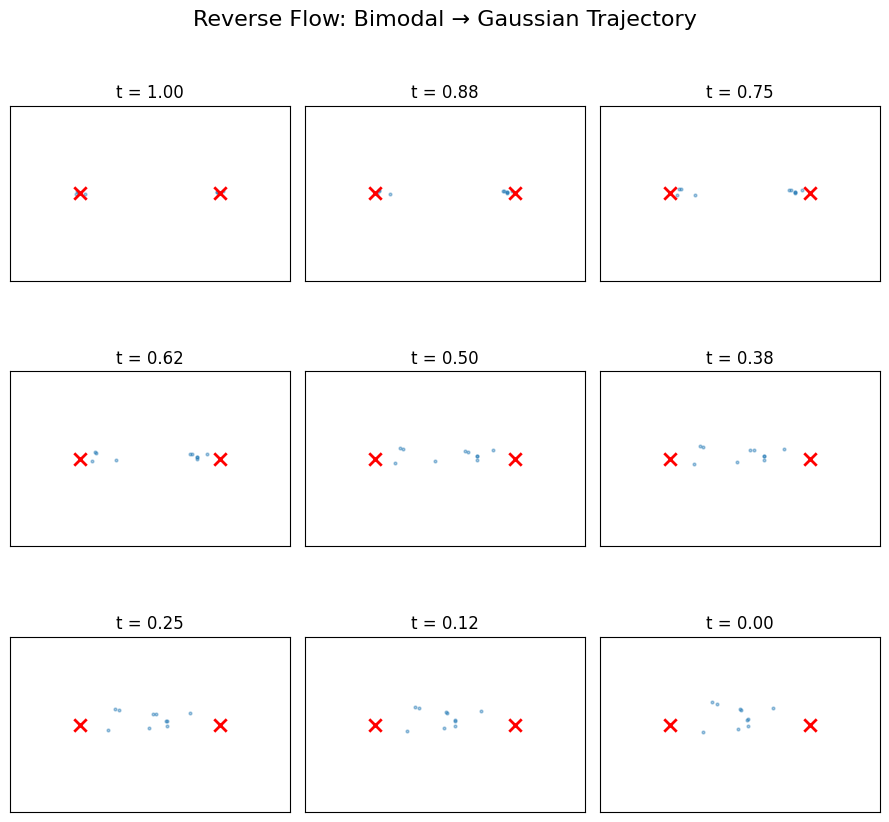

, 
 xbs: tensor([[ 3.8452954292,  0.0965253413],
        [ 3.9570729733,  0.0462065637],
        [-4.2194271088, -0.0435035378],
        [-4.1495223045,  0.1160616130],
        [ 3.8091645241,  0.1020722687],
        [-4.1125130653,  0.1044461876],
        [-3.6928391457, -0.0352107584],
        [ 4.1617703438,  0.1072716117],
        [ 3.9592266083,  0.0095083741],
        [ 3.9539203644,  0.0434883796]])
 xbs_copy: tensor([[ 3.8452954292,  0.0965253413],
        [ 3.9570729733,  0.0462065637],
        [-4.2194271088, -0.0435035378],
        [-4.1495223045,  0.1160616130],
        [ 3.8091645241,  0.1020722687],
        [-4.1125130653,  0.1044461876],
        [-3.6928391457, -0.0352107584],
        [ 4.1617703438,  0.1072716117],
        [ 3.9592266083,  0.0095083741],
        [ 3.9539203644,  0.0434883796]], device='cuda:0')
xas: tensor([[ 0.0515181646,  0.8238704801],
        [ 0.4422259629,  0.2933823764],
        [-2.1247150898, -0.4302273691],
        [-1.6027384996,  1.258762836

In [30]:
# ------------------ 5''  逆向采样并记录轨迹 ------------------
@torch.no_grad()
def sample_trajectory_reverse(n_samples=1000,
							  steps=1000,
							  record_frames=10,
							  method="euler"):
	"""
	从目标分布出发，沿  -v_θ  积分，把样本推回高斯。
	返回 list[x_t]，长度 = record_frames + 1，x_t[0] 对应 t=1。
	"""
	# x = sample_target(n_samples)                   # 初始 t=1
	
	x = xbs.to(device)  # 从之前的 xbs 开始
	xbs_copy = x
	dt = 1.0 / steps
	save_idx = torch.linspace(0, steps, record_frames + 1,
							  dtype=torch.long)
	frames = []

	for i in range(steps + 1):
		if i in save_idx:
			frames.append(x.detach().cpu())
		if i == steps:
			break

		t = torch.full((n_samples, 1),
					   1.0 - i * dt,              # 当前时间
					   device=device)
		v = model(x, t)

		if method == "euler":
			x = x - v * dt                       # 负向量场
		else:                                    # RK4，负 dt
			k1 = -v
			k2 = -(model(x + 0.5 * dt * k1, t - 0.5 * dt))
			k3 = -(model(x + 0.5 * dt * k2, t - 0.5 * dt))
			k4 = -(model(x + dt * k3,       t - dt))
			x = x + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)

	xcs = x.detach().cpu()  # 最终 x，用于可视化
	return frames, xbs_copy, xcs        # list[Tensor]，每个 (B, d)
# ------------------ 6''  逆向可视化 ------------------
frames_rev, xbs_copy, xcs = sample_trajectory_reverse(n_samples=10,
									   steps=10,
									   record_frames=8,
									   method="rk4")

fig, axes = plt.subplots(3, 3, figsize=(9, 9))
axes = axes.flatten()

for k, (ax, pts) in enumerate(zip(axes, frames_rev)):
	ax.scatter(pts[:, 0], pts[:, 1], s=4, alpha=0.4)
	ax.scatter(modes[:, 0].cpu(), modes[:, 1].cpu(),
			   c="red", marker="x", s=80, linewidths=2)
	ax.set_title(f"t = {1 - k / (len(frames_rev)-1):.2f}")
	ax.set_xlim(-8, 8); ax.set_ylim(-5, 5)
	ax.set_xticks([]); ax.set_yticks([]); ax.set_aspect("equal")

fig.suptitle("Reverse Flow: Bimodal → Gaussian Trajectory", fontsize=16)
plt.tight_layout()
plt.show()

torch.set_printoptions(precision=10)

# 示例打印
print(f", \n xbs: {xbs}\n xbs_copy: {xbs_copy}")
print(f"xas: {xas}, \n xcs: {xcs}\n")

diff = xcs - xas
diff_std = diff.std(unbiased=False)  # 如果你想除以 N，不加的话是除以 N-1
diff_mean = diff.mean()

print(f"diff std: {diff_std:.10f}")
print(f"diff mean: {diff_mean:.10f}")
print(f"diff abs mean: {diff.abs().mean():.10f}")
print(f"diff max: {diff.abs().max():.10f}")

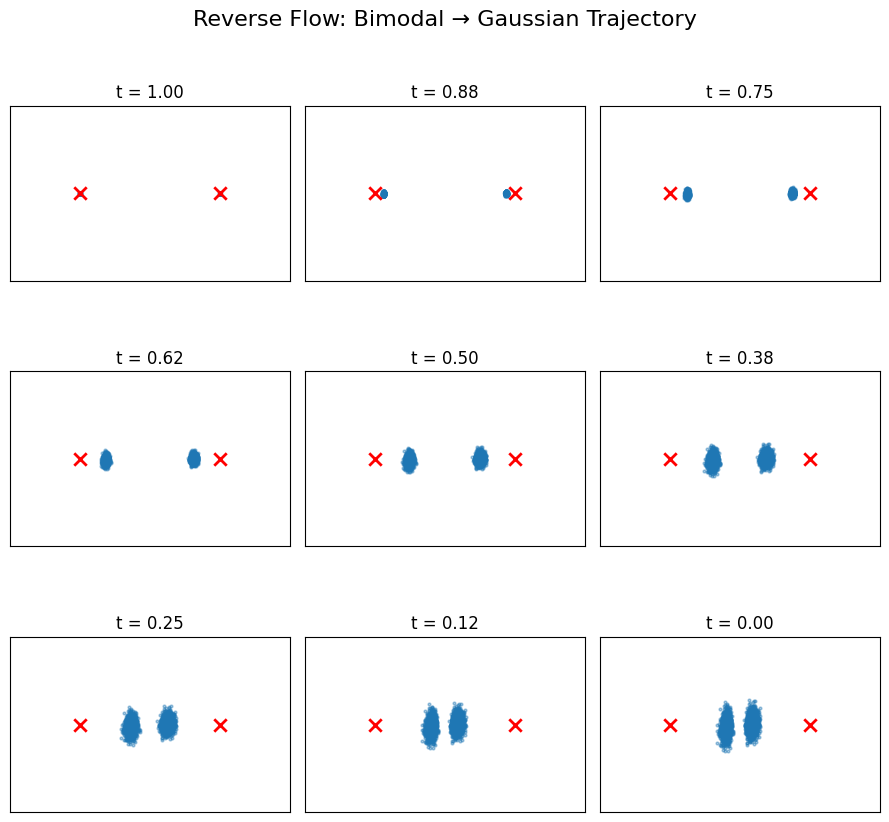

In [14]:
# ------------------ 5''  逆向采样并记录轨迹 ------------------
@torch.no_grad()
def sample_trajectory_reverse(n_samples=1000,
                              steps=1000,
                              record_frames=10,
                              method="euler"):
    """
    从目标分布出发，沿  -v_θ  积分，把样本推回高斯。
    返回 list[x_t]，长度 = record_frames + 1，x_t[0] 对应 t=1。
    """
    x = sample_target(n_samples)                   # 初始 t=1
    x = x + torch.randn_like(x) * 0.01  # 加点噪声，形成高斯
    dt = 1.0 / steps
    save_idx = torch.linspace(0, steps, record_frames + 1,
                              dtype=torch.long)
    frames = []

    for i in range(steps + 1):
        if i in save_idx:
            frames.append(x.detach().cpu())
        if i == steps:
            break

        t = torch.full((n_samples, 1),
                       1.0 - i * dt,              # 当前时间
                       device=device)
        v = model(x, t)

        if method == "euler":
            x = x - v * dt                       # 负向量场
        else:                                    # RK4，负 dt
            k1 = -v
            k2 = -(model(x + 0.5 * dt * k1, t - 0.5 * dt))
            k3 = -(model(x + 0.5 * dt * k2, t - 0.5 * dt))
            k4 = -(model(x + dt * k3,       t - dt))
            x = x + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)

    return frames        # list[Tensor]，每个 (B, d)
# ------------------ 6''  逆向可视化 ------------------
frames_rev = sample_trajectory_reverse(n_samples=4000,
                                       steps=800,
                                       record_frames=8,
                                       method="rk4")

fig, axes = plt.subplots(3, 3, figsize=(9, 9))
axes = axes.flatten()

for k, (ax, pts) in enumerate(zip(axes, frames_rev)):
    ax.scatter(pts[:, 0], pts[:, 1], s=4, alpha=0.4)
    ax.scatter(modes[:, 0].cpu(), modes[:, 1].cpu(),
               c="red", marker="x", s=80, linewidths=2)
    ax.set_title(f"t = {1 - k / (len(frames_rev)-1):.2f}")
    ax.set_xlim(-8, 8); ax.set_ylim(-5, 5)
    ax.set_xticks([]); ax.set_yticks([]); ax.set_aspect("equal")

fig.suptitle("Reverse Flow: Bimodal → Gaussian Trajectory", fontsize=16)
plt.tight_layout()
plt.show()
